# Autoencoder
#*Jan Miksa*

In [25]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
import math

In [26]:
batch_size = 64
image_size = 28
channels = 1

C = channels*image_size**2

In [27]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

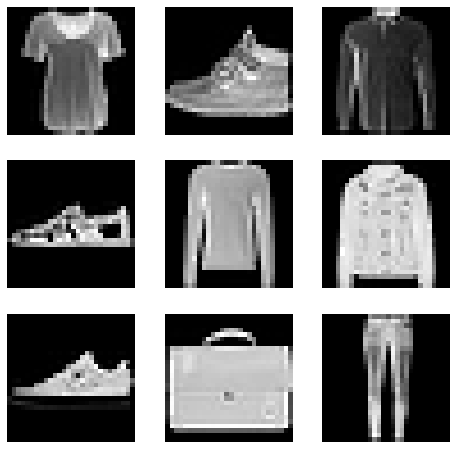

In [28]:
fig = plt.figure(figsize=(8, 8))
for i in range(9):
  ridx = torch.randint(len(training_data), size=(1,)).item()
  fig.add_subplot(3, 3, i+1)
  plt.axis("off")
  plt.imshow(training_data.data[ridx], cmap='gray')
plt.show()

In [29]:
class Encoder(nn.Module):
    def __init__(self, kernel_size):
        #print("Encoder")
        super(Encoder, self).__init__()
        self.kernel_size = kernel_size
        self.convl = []
        self.build()

    def build(self):
        curr = channels
        i = 0
        while curr < C:
            self.convl.append(curr)
            #print(i)
            next = curr*(self.kernel_size**2)
            self.add_module(f"layer{i}", nn.Conv2d(curr, next, self.kernel_size))
            curr = next
            i = i+1
        self.convl.append(curr)

    def forward(self, x):
        modulegen = self.modules()
        next(modulegen)
        for l in modulegen:
            x = l(x)
        return x


class Decoder(nn.Module):
    def __init__(self, kernel_size, convl):
        #print("Decoder")
        super(Decoder, self).__init__()
        self.kernel_size = kernel_size
        self.convl = convl
        self.build()

    def build(self):
        for i in range(len(self.convl)-1):
            #print(i)
            self.add_module(f"layer{i}", nn.ConvTranspose2d(self.convl[i], self.convl[i+1], self.kernel_size))
            i = i+1

    def forward(self, x):
        modulegen = self.modules()
        next(modulegen)
        for l in modulegen:
            x = l(x)
        return x

class Autoencoder(nn.Module):
    def __init__(self, in_channels, kernel_size):
        super(Autoencoder, self).__init__()
        self.enc = Encoder(3)
        #print("AE")
        self.enc.convl.reverse()
        self.dec = Decoder(3, self.enc.convl)
        #print("DE")

    def forward(self, x):
        x = self.enc.forward(x)
        #x = torch.reshape()
        x = self.dec.forward(x)
        return x

In [30]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

model = Autoencoder(1, 3).to(device)
print(model)

loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

Using cuda device


RuntimeError: ignored

In [17]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)

        res = model(X)
        loss = loss_fn(res, X)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device)
            res = model(X)
            test_loss += loss_fn(res, X).item()
    test_loss /= num_batches
    print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")

In [18]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------


RuntimeError: ignored

In [ ]:
#Porównanie przed i po obrazków